In [1]:
import pandas as pd
import pandas_ta as ta
import pandas as pd
import numpy as np
import sys
# import snowflake.connector
import ast
# from pandas.io.json import json_normalize
import json
from datetime import date
from datetime import timedelta
import os

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',200)
from IPython.display import display
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf
import pandas as pd
import time

from scipy.optimize import minimize

import seaborn as sns

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage,dendrogram

In [2]:
nifty_100 = pd.read_csv(r"C:\Users\Akash Dixit\Downloads\ind_nifty100list (1).csv")
indian_tickers = []

for i in nifty_100['Symbol'].unique():
    temp = f"{i}.NS"
    indian_tickers.append(temp)

results = []

for symbol in indian_tickers:
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        
        dct = {
            'Ticker': symbol,
            'Company': info.get('longName'),
            'Sector': info.get('sector'),
            'Industry': info.get('industry'),
            'MarketCap': info.get('marketCap')
        }
        
        results.append(dct)
        time.sleep(0.5)  
        
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")


company_details = pd.DataFrame(results)


company_details['MarketCap_Cr'] = company_details['MarketCap'] / 1e7

print(company_details.head())




          Ticker                                        Company       Sector  \
0         ABB.NS                              ABB India Limited  Industrials   
1  ADANIENSOL.NS                 Adani Energy Solutions Limited    Utilities   
2    ADANIENT.NS                      Adani Enterprises Limited       Energy   
3  ADANIGREEN.NS                     Adani Green Energy Limited    Utilities   
4  ADANIPORTS.NS  Adani Ports and Special Economic Zone Limited  Industrials   

                                  Industry      MarketCap   MarketCap_Cr  
0           Specialty Industrial Machinery  1065049587712  106504.958771  
1  Utilities - Independent Power Producers   949011218432   94901.121843  
2                             Thermal Coal  2518074261504  251807.426150  
3                    Utilities - Renewable  1533787373568  153378.737357  
4                          Marine Shipping  2907833106432  290783.310643  


### Price Generator

In [3]:
class Price_Generator:

    def __init__(self,ticker,company_details):
        self.ticker = ticker
        self.company_details = company_details
        self.data = None

        if self.company_details is not None:
            self.company_details['company'] = self.company_details['Ticker'].str.replace(".NS", "", regex=False)


    def fetch_price(self,start_date,end_date):
            self.data = yf.download(self.ticker,start=start_date,end=end_date)
            self.data.columns = [f"{ticker.split('.')[0]}_{typ}" for typ, ticker in self.data.columns]
            return self.data

    def price_generation(self):
        if self.data is None:
            raise ValueError('Please run first fetch_price() before generating Price.')

        df = self.data.sort_index().reset_index()
        price_cols = [x for x in df.columns if 'Close' in x]
        
        melted = df.melt(id_vars='Date',
                         value_vars=price_cols,
                         var_name='company',
                         value_name='price')
        
        melted['company'] = melted['company'].str.replace("_Close","",regex=False)
        company_details['company'] = company_details['Ticker'].str.replace(".NS","",regex=False)
    
        melted = pd.merge(melted,
                         company_details,
                         on='company',
                         how='left')
        
        # melted = melted[melted['price'].notna()]
        
        # Daily Return
        melted['daily_return'] = (
            
            melted.sort_values(by=['company','Date'])
            .groupby(['company'])['price']
            .transform('pct_change')
        )
        melted['daily_return'] = melted['daily_return'].fillna(0)
        print('Generated Daily Return')

        # Cummulaive Return
        melted['Cummulative_return'] = (
            
            melted.sort_values(by=['company','Date'])
            .groupby(['company'])['daily_return']
            .transform(lambda x:(1+x).cumprod()-1)
        )
        print('Generatd Cummulative Return')
        
        
        return melted.drop(columns=['Ticker', 'Company'], errors='ignore')
            

processor = Price_Generator(ticker=indian_tickers,company_details=company_details)
#  Select Date
processor.fetch_price(start_date='2023-01-01',end_date='2025-06-30')
final_price_df = processor.price_generation()

[*********************100%***********************]  100 of 100 completed


Generated Daily Return
Generatd Cummulative Return


#### Split into Train and Test

In [4]:
final_price_df_train = final_price_df[final_price_df['Date']<=pd.to_datetime('2023-12-31',format="%Y-%m-%d")]
final_price_df_test = final_price_df[final_price_df['Date']>pd.to_datetime('2023-12-31',format="%Y-%m-%d")]

## Heirerchal Risk Parity

## Key idea:
#### Cluster assets based on correlations (hierarchical clustering).
#### Allocate risk within and across clusters using inverse-variance logic.
#### No need to invert the covariance matrix → more robust in noisy data.

In [5]:
daily_return = final_price_df_train.pivot(index='Date',
                                         columns='company',
                                         values='daily_return')

nan_companies = ['ADANIENSOL','BAJAJHFL','ETERNAL','HYUNDAI','JIOFIN','SWIGGY','UNITDSPR']
daily_return = daily_return.drop(columns=nan_companies, errors='ignore')

In [6]:
cov = daily_return.cov()
corr = daily_return.corr()

In [7]:
def distance(corr_):
    return np.sqrt(0.5 * (1-corr_))


def quasi_diagonalization(matrix):
    
    temp_matrix = matrix.astype(int)
    root_node = pd.Series([temp_matrix[-1,0],temp_matrix[-1,1]])
    num_assets = temp_matrix[-1,-1]
    
    while root_node.max() >= num_assets:
        root_node.index = range(0,root_node.shape[0]*2,2)
        # display(root_node)
        dx0 = root_node[root_node>=num_assets]
        # display(dx0)
        for i in dx0.index:
            root_i = root_node[i]
            root_node[i] = temp_matrix[int(root_i-num_assets),0]
            
            root_node = pd.concat([root_node.iloc[:i+1],
                                 pd.Series(temp_matrix[int(root_i-num_assets),1]),
                                 root_node.iloc[i+1:]
                                  ])
    lst = root_node.tolist()
    return lst
            # display(root_node)

    
def get_variance(cov,items):
    cov_ = cov.loc[items,items]
    w_ = np.linalg.inv(cov_).sum(axis=1)
    w_ /= w_.sum()
    return np.dot(np.dot(w_,cov_),w_)



def recursive_bisection(ticker):
    tick = [ticker]
    w = pd.Series(1,index=ticker)
    
    while len(tick)>0:
        tick = [i[j:k] for i in tick for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1]
    
        for i in range(0,len(tick),2):
            c0 = tick[i]
            c1 = tick[i+1]
            # print(c0)
            var0 = get_variance(cov,c0)
            var1 = get_variance(cov,c1)
            alpha = 1 - (var0/(var0+var1))
            w[c0] *= alpha
            w[c1] *= 1-alpha
    return w

dist_matrix = distance(corr)
linkage_matrix = linkage(squareform(dist_matrix),method='single')
quasi_diagonal = quasi_diagonalization(linkage_matrix)
sorted_tickers = cov.index[quasi_diagonal]
hrp_weight = recursive_bisection(sorted_tickers)

In [8]:
hrp_weight.sum()

1.0

0.01

### Mean Varaince Optimization

In [9]:
corr = daily_return.corr()
mean = daily_return.mean()
cov = daily_return.cov()
var = daily_return.var()
assets = cov.columns.tolist()

In [82]:
# Mean-Variance Optimization (MVO)
# ---------------------------------
# Introduced by Harry Markowitz (1952), MVO selects portfolio weights 
# that minimize risk for a target return or maximize return for a given risk.
#
# Problem formulation:
#   minimize   wᵀ Σ w
#   subject to μᵀ w = R_target,  Σ w = 1
#
# Where:
#   w   = vector of portfolio weights
#   Σ   = covariance matrix of asset returns
#   μ   = expected returns vector
#
# Intuition:
# - Risk is measured by portfolio variance: σ_p² = wᵀ Σ w
# - Return is expected portfolio mean: μ_p = μᵀ w
# - The efficient frontier is the set of optimal portfolios for different risk levels.
#
# Limitations:
# - Requires accurate estimates of μ and Σ (both sensitive to noise).
# - Covariance matrix inversion can be unstable when assets are highly correlated.
# - Small changes in inputs can cause large shifts in weights.


In [11]:
def portfolio_volatility(w,cov):
    return np.sqrt(np.dot(w.T,np.dot(cov,w)))

def portfolio_return(w,mean):
    return np.dot(w,mean)

num_assets = len(assets)

# Starting with Randomly Assigned Weights
init_guess = np.random.dirichlet(np.ones(num_assets), size=1)[0]
bound = tuple((0,0.12) for _ in range(num_assets))
target = 0.001 # Target Return daily here i kep at 1%

constratints = (
    {'type':'eq','fun':lambda w :np.sum(w)-1}, # Make sure weight sum is Equal to 1
    {'type':'eq','fun':lambda w:portfolio_return(w,mean)-target} # Make Sure Portfolio Return = Target Return
)

result = minimize(portfolio_volatility,
                 init_guess,
                 bounds=bound,
                 method='SLSQP',
                 args=(cov,),
                 constraints=constratints
                 )

optimal_weights = result.x
print(result.message)
print("\n-----> Expected Daily Return:", portfolio_return(optimal_weights, mean))
print("-----> Expected Daily Volatility:", portfolio_volatility(optimal_weights, cov))


Optimization terminated successfully

-----> Expected Daily Return: 0.0010000000000392958
-----> Expected Daily Volatility: 0.004557780908946136


In [12]:
mean_var_weights = pd.DataFrame(optimal_weights,index=assets)
mean_var_weights.rename(columns={0:'mvo_weight'},inplace=True)
mean_var_weights['mvo_weight'] = round(mean_var_weights['mvo_weight'],7)

mean_var_weight_dict = dict(zip(assets,optimal_weights))

### Equal Weights

In [13]:
num_assets = len(assets)
equal_w = num_assets * [1/num_assets]
equal_weight = dict(zip(assets,equal_w))

### Risk Parity

In [14]:
def calculate_portfolio_volatility(w,cov):
    return np.sqrt(w.T @ cov @ w)

def calculate_marginal_risk(w,cov):
    portfolio_vol = calculate_portfolio_volatility(w,cov)
    marginal_contribution = cov @ w
    risk_contribution = marginal_contribution * w
    return risk_contribution/portfolio_vol

def get_risk_parity(w,cov):
    risk_contrib = calculate_marginal_risk(w,cov)
    mean_risk = risk_contrib.mean()
    return np.sum((risk_contrib-mean_risk)**2)

def ret_risk_parity_weight(cov):
    num_assets = cov.shape[0]
    # init_guess = np.ones(num_assets)/num_assets
    init_guess = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    bound = [(0,0.30) for _ in range(num_assets)]
    constraints = ({'type':'eq','fun':lambda w:np.sum(w)-1})
    
    result = minimize(fun=get_risk_parity,
                     x0=init_guess,
                     args=(cov,),
                     bounds=bound,
                     method='SLSQP',
                     constraints=constraints)
    if result.success:
        return result.x
    else:
        print('Process Failed')

In [15]:
rp_weights = ret_risk_parity_weight(cov)


In [16]:
equal_weight

{'ABB': 0.010752688172043012,
 'ADANIENT': 0.010752688172043012,
 'ADANIGREEN': 0.010752688172043012,
 'ADANIPORTS': 0.010752688172043012,
 'ADANIPOWER': 0.010752688172043012,
 'AMBUJACEM': 0.010752688172043012,
 'APOLLOHOSP': 0.010752688172043012,
 'ASIANPAINT': 0.010752688172043012,
 'AXISBANK': 0.010752688172043012,
 'BAJAJ-AUTO': 0.010752688172043012,
 'BAJAJFINSV': 0.010752688172043012,
 'BAJAJHLDNG': 0.010752688172043012,
 'BAJFINANCE': 0.010752688172043012,
 'BANKBARODA': 0.010752688172043012,
 'BEL': 0.010752688172043012,
 'BHARTIARTL': 0.010752688172043012,
 'BOSCHLTD': 0.010752688172043012,
 'BPCL': 0.010752688172043012,
 'BRITANNIA': 0.010752688172043012,
 'CANBK': 0.010752688172043012,
 'CGPOWER': 0.010752688172043012,
 'CHOLAFIN': 0.010752688172043012,
 'CIPLA': 0.010752688172043012,
 'COALINDIA': 0.010752688172043012,
 'DABUR': 0.010752688172043012,
 'DIVISLAB': 0.010752688172043012,
 'DLF': 0.010752688172043012,
 'DMART': 0.010752688172043012,
 'DRREDDY': 0.0107526881720

In [17]:
rp_weights

array([0.00979682, 0.00772464, 0.00950935, 0.00195457, 0.00070014,
       0.01262412, 0.00709272, 0.01098206, 0.01066065, 0.01257243,
       0.00181049, 0.00795579, 0.00172888, 0.01077341, 0.02381204,
       0.00932494, 0.0125932 , 0.00569325, 0.02436378, 0.00399715,
       0.01021421, 0.00290364, 0.00747789, 0.00595945, 0.01177155,
       0.00967895, 0.00633394, 0.02281448, 0.00640352, 0.0022259 ,
       0.03726499, 0.00181905, 0.00428866, 0.00332344, 0.04605664,
       0.00362128, 0.00833858, 0.00161263, 0.00850972, 0.00291538,
       0.00059952, 0.03814351, 0.00863985, 0.00915664, 0.00021245,
       0.0183305 , 0.02158344, 0.00054669, 0.00789758, 0.00180865,
       0.00146266, 0.02934648, 0.01999698, 0.00782366, 0.00164044,
       0.00644992, 0.00410729, 0.00377048, 0.00018147, 0.00082607,
       0.00215246, 0.01372593, 0.0073169 , 0.00672871, 0.02179298,
       0.01518231, 0.01450254, 0.00115495, 0.0049735 , 0.0203136 ,
       0.00122539, 0.0059353 , 0.00173317, 0.00915094, 0.00638

#### Mapping with Daily return's

In [18]:
final_price_df_train['hrp_weights'] = final_price_df_train['company'].map(dict(hrp_weight))
final_price_df_train['mean_var_opt_weights'] = final_price_df_train['company'].map(mean_var_weight_dict)
final_price_df_train['equal_weights'] = final_price_df_train['company'].map(equal_weight)
final_price_df_train['mean_var_opt_weights'] = round(final_price_df_train['mean_var_opt_weights'],6)
final_price_df_train['risk_parity_weights'] = final_price_df_train['company'].map(dict(zip(sorted_tickers,rp_weights)))

In [19]:
final_price_df_train = final_price_df_train[~(final_price_df_train['company'].isin(['ADANIENSOL','BAJAJHFL','ETERNAL',
                                                                                    'HYUNDAI','JIOFIN','SWIGGY','UNITDSPR']))]

final_price_df_test = final_price_df_test[~(final_price_df_test['company'].isin(['ADANIENSOL','BAJAJHFL','ETERNAL',
                                                                                    'HYUNDAI','JIOFIN','SWIGGY','UNITDSPR']))]

In [20]:
def portfolio_generation(df,invest_amount):

    initial_price = (
        df.sort_values(by=['company','Date'])
        .groupby('company')
        .first()
    ).reset_index()

    for weight in [x for x in initial_price.columns if 'weights' in x]:
        if 'hrp' in weight.lower():
            initial_price['HRP_capital_allocated'] = initial_price[weight] * invest_amount
            initial_price['HRP_unit_allocated'] = (initial_price['HRP_capital_allocated'] / initial_price['price'])
        elif 'mean_var' in weight.lower():
            initial_price['MeanVar_Opt_capital_allocated'] =  initial_price[weight] * invest_amount
            initial_price['MeanVar_Opt_unit_allocated'] = (initial_price['MeanVar_Opt_capital_allocated'] / initial_price['price'])
        elif 'equal' in weight.lower() :
            initial_price['Equal_Weight_capital_allocated'] = initial_price[weight] * invest_amount
            initial_price['Equal_Weight_unit_allocated'] = (initial_price['Equal_Weight_capital_allocated'] / initial_price['price'])
        elif 'risk_parity' in weight.lower() :
            initial_price['Risk_Parity_capital_allocated'] = initial_price[weight] * invest_amount
            initial_price['RiskParity_unit_allocated'] = (initial_price['Risk_Parity_capital_allocated'] / initial_price['price'])
        else:
            pass

    unit_cols = ['company'] + [x for x in initial_price.columns if 'unit_allocated' in x]
    unit_df = initial_price[unit_cols]

    portfolio_price = pd.merge(df,
                          unit_df,
                          on='company',
                          how='left')

    
    
    for i in [x for x in portfolio_price.columns if 'unit_allocated' in x]:
        lst = i.split('_unit')
        # display(lst[0])
        portfolio_price[f"{lst[0]}_position_value"] = portfolio_price[i] * portfolio_price['price']
    
    overall_portfolio = portfolio_price.groupby(['Date'])[[x for x in portfolio_price.columns if '_position_value' in x]].sum().reset_index()
    
    for value in  [x for x in overall_portfolio.columns if '_position_value' in x]:
        # print(value)
        overall_portfolio[f"{(value.split('_'))[0]}_daily_return"] = overall_portfolio[value].pct_change()
        overall_portfolio[f"{(value.split('_'))[0]}_daily_return"] = overall_portfolio[f"{(value.split('_'))[0]}_daily_return"].fillna(0)
        overall_portfolio[f"{(value.split('_'))[0]}_rolling_volatility_21D"] = overall_portfolio[f"{(value.split('_'))[0]}_daily_return"].rolling(window=21).std()
    
        
        overall_portfolio[f"{(value.split('_'))[0]}_cummulative_return"] = (1 + overall_portfolio[f"{(value.split('_'))[0]}_daily_return"]
                                                                           ).cumprod() - 1
    return overall_portfolio,portfolio_price

    
    

In [21]:
portfolio_return_train,ovrall_portfolio_train = portfolio_generation(final_price_df_train,100000)

In [22]:
portfolio_return_train

,Date,HRP_position_value,MeanVar_Opt_position_value,Equal_Weight_position_value,RiskParity_position_value,HRP_daily_return,HRP_rolling_volatility_21D,HRP_cummulative_return,MeanVar_daily_return,MeanVar_rolling_volatility_21D,MeanVar_cummulative_return,Equal_daily_return,Equal_rolling_volatility_21D,Equal_cummulative_return,RiskParity_daily_return,RiskParity_rolling_volatility_21D,RiskParity_cummulative_return
0,2023-01-02,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
1,2023-01-03,100312.792889,100277.345535,100402.782131,100391.192244,0.003128,NaN,0.003128,0.002773,NaN,0.002773,0.004028,NaN,0.004028,0.003912,NaN,0.003912
2,2023-01-04,99359.696844,99793.136597,99279.817814,99344.446463,-0.009501,NaN,-0.006403,-0.004829,NaN,-0.002069,-0.011185,NaN,-0.007202,-0.010427,NaN,-0.006556
3,2023-01-05,99721.061186,100173.047337,99628.559561,99623.564310,0.003637,NaN,-0.002789,0.003807,NaN,0.001730,0.003513,NaN,-0.003714,0.002810,NaN,-0.003764
4,2023-01-06,99014.533638,99660.976285,98900.899580,98867.370748,-0.007085,NaN,-0.009855,-0.005112,NaN,-0.003390,-0.007304,NaN,-0.010991,-0.007591,NaN,-0.011326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2023-12-22,133356.933166,124208.926400,141767.955365,137056.230066,0.008254,0.006996,0.333569,0.005099,0.004343,0.242089,0.007448,0.009066,0.417680,0.005159,0.009005,0.370562
241,2023-12-26,134434.583874,125156.857572,143012.573705,138175.464613,0.008081,0.007016,0.344346,0.007632,0.004398,0.251569,0.008779,0.009065,0.430126,0.008166,0.009033,0.381755
242,2023-12-27,135416.668086,125825.193566,143868.269989,139213.823286,0.007305,0.006911,0.354167,0.005340,0.004342,0.258252,0.005983,0.008953,0.438683,0.007515,0.008922,0.392138
243,2023-12-28,136377.549383,126659.169823,144811.010525,140431.457341,0.007096,0.006913,0.363775,0.006628,0.004409,0.266592,0.006553,0.008906,0.448110,0.008747,0.008783,0.404315


#### Mapping Nifty Also

In [23]:
def get_nifty_data(start_date,end_date):
    
    price = yf.download(tickers='^NSEI',start=start_date,end=end_date)
    price.columns = [f"{ticker.split('.')[0]}_{typ}" for typ, ticker in price.columns]
    price = price.reset_index()
    
    nifty_df = price[['Date','^NSEI_Close']]
    
    nifty_df['daily_return'] = nifty_df['^NSEI_Close'].pct_change()
    nifty_df['daily_return'] = nifty_df['daily_return'].fillna(0)
    nifty_df['index_cummulative_return'] = (1+ nifty_df['daily_return']).cumprod() -1
    
    
    investment_amount = 100000
    nifty_df['index_value'] = (1+nifty_df['index_cummulative_return'])*investment_amount
    nifty_df['rolling_volatility_21D'] = nifty_df['daily_return'].rolling(window=21).std()
    return nifty_df
    

In [24]:
portfolio_return_train

,Date,HRP_position_value,MeanVar_Opt_position_value,Equal_Weight_position_value,RiskParity_position_value,HRP_daily_return,HRP_rolling_volatility_21D,HRP_cummulative_return,MeanVar_daily_return,MeanVar_rolling_volatility_21D,MeanVar_cummulative_return,Equal_daily_return,Equal_rolling_volatility_21D,Equal_cummulative_return,RiskParity_daily_return,RiskParity_rolling_volatility_21D,RiskParity_cummulative_return
0,2023-01-02,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
1,2023-01-03,100312.792889,100277.345535,100402.782131,100391.192244,0.003128,NaN,0.003128,0.002773,NaN,0.002773,0.004028,NaN,0.004028,0.003912,NaN,0.003912
2,2023-01-04,99359.696844,99793.136597,99279.817814,99344.446463,-0.009501,NaN,-0.006403,-0.004829,NaN,-0.002069,-0.011185,NaN,-0.007202,-0.010427,NaN,-0.006556
3,2023-01-05,99721.061186,100173.047337,99628.559561,99623.564310,0.003637,NaN,-0.002789,0.003807,NaN,0.001730,0.003513,NaN,-0.003714,0.002810,NaN,-0.003764
4,2023-01-06,99014.533638,99660.976285,98900.899580,98867.370748,-0.007085,NaN,-0.009855,-0.005112,NaN,-0.003390,-0.007304,NaN,-0.010991,-0.007591,NaN,-0.011326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2023-12-22,133356.933166,124208.926400,141767.955365,137056.230066,0.008254,0.006996,0.333569,0.005099,0.004343,0.242089,0.007448,0.009066,0.417680,0.005159,0.009005,0.370562
241,2023-12-26,134434.583874,125156.857572,143012.573705,138175.464613,0.008081,0.007016,0.344346,0.007632,0.004398,0.251569,0.008779,0.009065,0.430126,0.008166,0.009033,0.381755
242,2023-12-27,135416.668086,125825.193566,143868.269989,139213.823286,0.007305,0.006911,0.354167,0.005340,0.004342,0.258252,0.005983,0.008953,0.438683,0.007515,0.008922,0.392138
243,2023-12-28,136377.549383,126659.169823,144811.010525,140431.457341,0.007096,0.006913,0.363775,0.006628,0.004409,0.266592,0.006553,0.008906,0.448110,0.008747,0.008783,0.404315


### Return Function Plot

In [126]:
def plot_data(nifty,df):
    
    highlight_date = df['Date'].max()
    highlight_date = pd.to_datetime(highlight_date,format="%Y-%m-%d")
    index_return = f"{round(nifty[nifty['Date'] == highlight_date]['index_cummulative_return'].iloc[0] * 100, 2)}%"
    hrp_return = f"{round(df[df['Date'] == highlight_date]['HRP_cummulative_return'].iloc[0] * 100, 2)}%"
    meanvar_return = f"{round(df[df['Date'] == highlight_date]['MeanVar_cummulative_return'].iloc[0] * 100, 2)}%"
    equaldaily_return = f"{round(df[df['Date'] == highlight_date]['Equal_cummulative_return'].iloc[0] * 100, 2)}%"
    riskparity_return = f"{round(df[df['Date'] == highlight_date]['RiskParity_cummulative_return'].iloc[0] * 100, 2)}%"
    
    index_return_val = nifty[nifty['Date'] == highlight_date]['index_cummulative_return'].iloc[0]
    hrp_return_val = df[df['Date'] == highlight_date]['HRP_cummulative_return'].iloc[0]
    meanvar_return_val = df[df['Date'] == highlight_date]['MeanVar_cummulative_return'].iloc[0]
    equaldaily_return_val = df[df['Date'] == highlight_date]['Equal_cummulative_return'].iloc[0]
    riskparity_return_val = df[df['Date'] == highlight_date]['RiskParity_cummulative_return'].iloc[0]
    
    plt.figure(figsize=(16,8))
    
    sns.lineplot(data=nifty,
                x='Date',
                y='index_cummulative_return',
                color='black',
                linestyle= '--',
                label='Nifty Return')
    
    sns.lineplot(data=df,
                x='Date',
                y='HRP_cummulative_return',
                color='blue',
                label='HRP Return')
    
    sns.lineplot(data=df,
                x='Date',
                y='MeanVar_cummulative_return',
                color='red',
                label='Mean Var Opt. Return')
    
    sns.lineplot(data=df,
                x='Date',
                y='Equal_cummulative_return',
                color='green',
                label='Equal Weight Return')
    
    sns.lineplot(data=df,
                x='Date',
                y='RiskParity_cummulative_return',
                color='#BC8F8F',
                label='Risk Parity Return')
    
    plt.axhline(y=index_return_val, color='black', linestyle=':', linewidth=1)
    plt.axhline(y=hrp_return_val, color='blue', linestyle=':', linewidth=1)
    plt.axhline(y=meanvar_return_val, color='red', linestyle=':', linewidth=1)
    plt.axhline(y=equaldaily_return_val, color='green', linestyle=':', linewidth=1)
    plt.axhline(y=riskparity_return_val, color='#BC8F8F', linestyle=':', linewidth=1)
    
    plt.text(highlight_date,
             index_return_val + 0.01,
             f"Nifty: {index_return}",
             color='black',
             fontsize=10,
             ha='left')
    
    plt.text(highlight_date,
             hrp_return_val + 0.01,
             f"HRP: {hrp_return}",
             color='blue',
             fontsize=10,
             ha='left')
    
    plt.text(highlight_date,
             meanvar_return_val + 0.01,
             f"Mean Var Opt.: {meanvar_return}",
             color='red',
             fontsize=10,
             ha='left')
    
    plt.text(highlight_date,
             equaldaily_return_val + 0.01,
             f"Equal Weight: {equaldaily_return}",
             color='green',
             fontsize=10,
             ha='left')

    plt.text(highlight_date,
             riskparity_return_val + 0.01,
             f"Risk Weight: {riskparity_return}",
             color='#BC8F8F',
             fontsize=10,
             ha='left')
    
    # plt.title('Nifty Index Vs Heirchal Risk Parity Return Vs Markowitz Optimizer Vs Equal Weighted Vs Risk Parity on (1L Invested)')
    plt.title('Optimizers Comparision (Test Data)')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.show()
    

In [26]:
nifty_2023 = get_nifty_data(start_date='2023-01-01',end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed


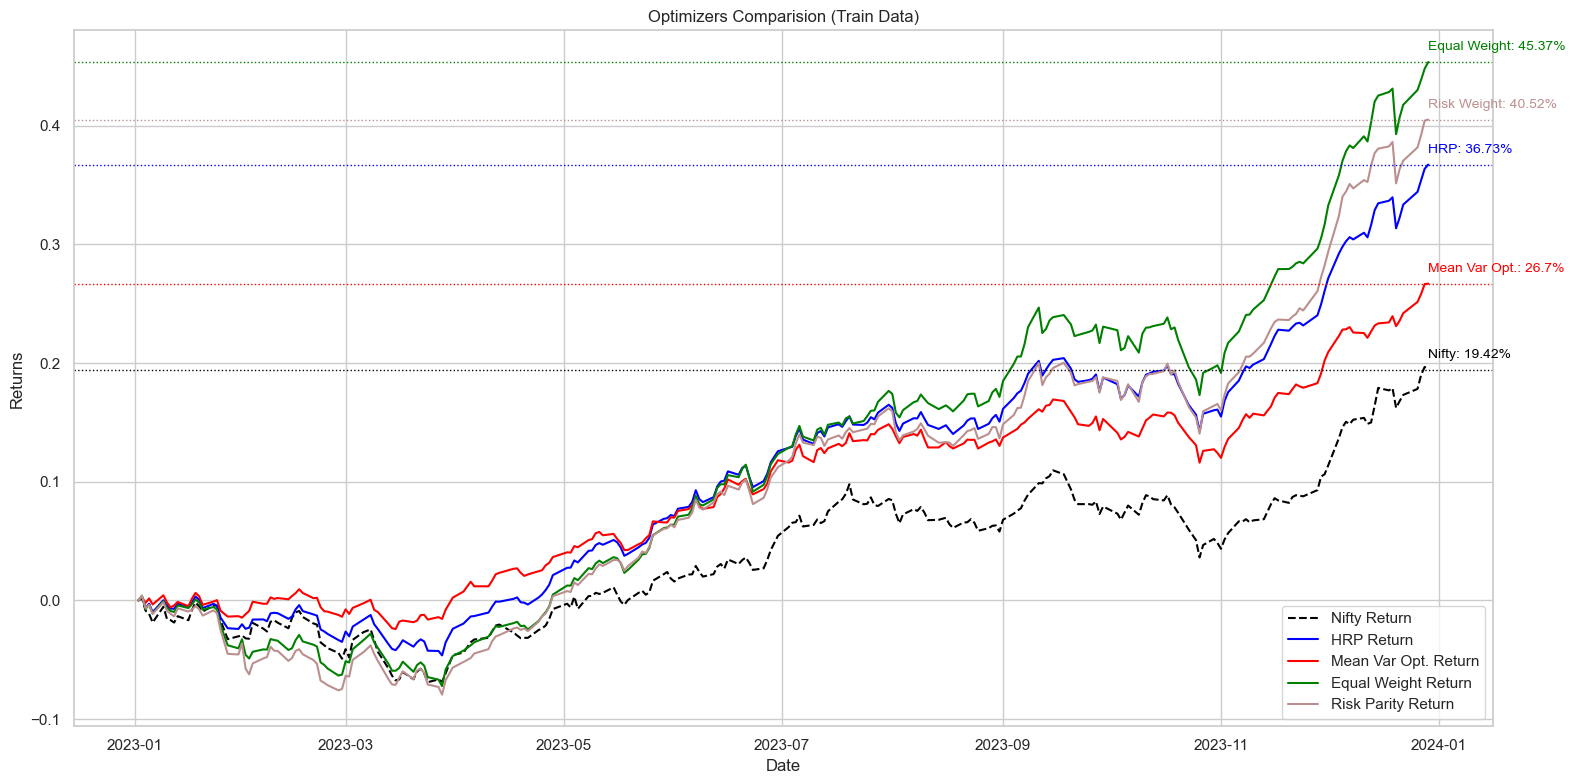

In [124]:
plot_data(nifty=nifty_2023,
         df=portfolio_return_train)

In [114]:
portfolio_return_train

,Date,HRP_position_value,MeanVar_Opt_position_value,Equal_Weight_position_value,RiskParity_position_value,HRP_daily_return,HRP_rolling_volatility_21D,HRP_cummulative_return,MeanVar_daily_return,MeanVar_rolling_volatility_21D,MeanVar_cummulative_return,Equal_daily_return,Equal_rolling_volatility_21D,Equal_cummulative_return,RiskParity_daily_return,RiskParity_rolling_volatility_21D,RiskParity_cummulative_return,HRP_drawdown,MeanVar_drawdown,Equal_drawdown,RiskParity_drawdown
0,2023-01-02,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-03,100312.792889,100277.345535,100402.782131,100391.192244,0.003128,NaN,0.003128,0.002773,NaN,0.002773,0.004028,NaN,0.004028,0.003912,NaN,0.003912,0.000000,0.000000,0.000000,0.000000
2,2023-01-04,99359.696844,99793.136597,99279.817814,99344.446463,-0.009501,NaN,-0.006403,-0.004829,NaN,-0.002069,-0.011185,NaN,-0.007202,-0.010427,NaN,-0.006556,-0.009501,-0.004829,-0.011185,-0.010427
3,2023-01-05,99721.061186,100173.047337,99628.559561,99623.564310,0.003637,NaN,-0.002789,0.003807,NaN,0.001730,0.003513,NaN,-0.003714,0.002810,NaN,-0.003764,-0.005899,-0.001040,-0.007711,-0.007646
4,2023-01-06,99014.533638,99660.976285,98900.899580,98867.370748,-0.007085,NaN,-0.009855,-0.005112,NaN,-0.003390,-0.007304,NaN,-0.010991,-0.007591,NaN,-0.011326,-0.012942,-0.006147,-0.014959,-0.015179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2023-12-22,133356.933166,124208.926400,141767.955365,137056.230066,0.008254,0.006996,0.333569,0.005099,0.004343,0.242089,0.007448,0.009066,0.417680,0.005159,0.009005,0.370562,-0.004580,0.000000,-0.009543,-0.011393
241,2023-12-26,134434.583874,125156.857572,143012.573705,138175.464613,0.008081,0.007016,0.344346,0.007632,0.004398,0.251569,0.008779,0.009065,0.430126,0.008166,0.009033,0.381755,0.000000,0.000000,-0.000847,-0.003320
242,2023-12-27,135416.668086,125825.193566,143868.269989,139213.823286,0.007305,0.006911,0.354167,0.005340,0.004342,0.258252,0.005983,0.008953,0.438683,0.007515,0.008922,0.392138,0.000000,0.000000,0.000000,0.000000
243,2023-12-28,136377.549383,126659.169823,144811.010525,140431.457341,0.007096,0.006913,0.363775,0.006628,0.004409,0.266592,0.006553,0.008906,0.448110,0.008747,0.008783,0.404315,0.000000,0.000000,0.000000,0.000000


### Testing

In [29]:
final_price_df_test['hrp_weights'] = final_price_df_test['company'].map(dict(hrp_weight))
final_price_df_test['mean_var_opt_weights'] = final_price_df_test['company'].map(mean_var_weight_dict)
final_price_df_test['equal_weights'] = final_price_df_test['company'].map(equal_weight)
final_price_df_test['mean_var_opt_weights'] = round(final_price_df_test['mean_var_opt_weights'],6)
final_price_df_test['risk_parity_weights'] = final_price_df_test['company'].map(dict(zip(sorted_tickers,rp_weights)))

In [30]:
portfolio_return_test,ovrall_portfolio_test = portfolio_generation(final_price_df_test,100000)
nifty_2024 = get_nifty_data(start_date='2024-01-01',end_date='2025-06-30')

[*********************100%***********************]  1 of 1 completed


In [31]:
portfolio_return_test

,Date,HRP_position_value,MeanVar_Opt_position_value,Equal_Weight_position_value,RiskParity_position_value,HRP_daily_return,HRP_rolling_volatility_21D,HRP_cummulative_return,MeanVar_daily_return,MeanVar_rolling_volatility_21D,MeanVar_cummulative_return,Equal_daily_return,Equal_rolling_volatility_21D,Equal_cummulative_return,RiskParity_daily_return,RiskParity_rolling_volatility_21D,RiskParity_cummulative_return
0,2024-01-01,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
1,2024-01-02,99759.774118,100231.182221,99722.125183,99964.832194,-0.002402,NaN,-0.002402,0.002312,NaN,0.002312,-0.002779,NaN,-0.002779,-0.000352,NaN,-0.000352
2,2024-01-03,99499.708819,100028.378405,99774.649362,100319.500501,-0.002607,NaN,-0.005003,-0.002023,NaN,0.000284,0.000527,NaN,-0.002254,0.003548,NaN,0.003195
3,2024-01-04,100287.776103,100685.364124,100831.121854,101202.535167,0.007920,NaN,0.002878,0.006568,NaN,0.006854,0.010589,NaN,0.008311,0.008802,NaN,0.012025
4,2024-01-05,100262.413595,100519.440972,100794.545806,101271.405953,-0.000253,NaN,0.002624,-0.001648,NaN,0.005194,-0.000363,NaN,0.007945,0.000681,NaN,0.012714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2025-06-23,121590.868399,117813.797979,123102.753258,124581.606649,-0.002283,0.006318,0.215909,-0.004891,0.005108,0.178138,-0.000485,0.007166,0.231028,-0.000806,0.006981,0.245816
364,2025-06-24,122200.494434,117881.235554,123864.516573,125643.150665,0.005014,0.006299,0.222005,0.000572,0.005017,0.178812,0.006188,0.007167,0.238645,0.008521,0.007106,0.256432
365,2025-06-25,122958.918839,118677.811682,124504.393399,126151.873720,0.006206,0.006325,0.229589,0.006757,0.005151,0.186778,0.005166,0.007179,0.245044,0.004049,0.007066,0.261519
366,2025-06-26,124072.269658,119539.585002,125739.258398,127575.861826,0.009055,0.006485,0.240723,0.007261,0.005121,0.195396,0.009918,0.007408,0.257393,0.011288,0.007439,0.275759


In [127]:
plot_data(nifty=nifty_2024,df=portfolio_return_test)
plt.savefig('Test_data_return.png')
plt.close()

In [125]:
plot_data(nifty=nifty_2023,df=portfolio_return_train)
plt.savefig('Train_data_return.png')
plt.close()

### sharpe Calculation

In [56]:
def sharpe_calculation(df):
    cols = [x for x in df.columns if 'daily_return' in x or 'rolling_volatility_21D' in x]
    uniq = [x for x in df.columns if 'daily_return' in x ]
    dct = {}

    for i in uniq:
        temp = i.replace("_daily_return","")
        returns = None
        vol = None
        
        for j in cols:
            if temp in j:
                if 'daily_return' in j:
                    returns =  (df[j].mean()) * 252
                elif 'rolling_volatility_21D' in j:
                    vol = (df[j].mean()) * (252 ** 0.5)
                else:
                    pass

        if returns is not None and vol is not None:
            sharpe = returns/vol
            dct[temp] = sharpe
            dff = pd.DataFrame([dct],index=['sharpe']).T
            print(f"{'Portfolio':<12}{'Sharpe Ratio'}")
            print(temp, round(sharpe, 3))
        else:
            print(f"Missing data for {temp}")
    return pd.DataFrame.from_dict(dct, orient='index', columns=['Sharpe'])
        
    

In [77]:
sharpe_test = sharpe_calculation(portfolio_return_test)
sharpe_train = sharpe_calculation(portfolio_return_train)

Portfolio   Sharpe Ratio
HRP 1.112
Portfolio   Sharpe Ratio
MeanVar 1.125
Portfolio   Sharpe Ratio
Equal 1.033
Portfolio   Sharpe Ratio
RiskParity 1.109
Portfolio   Sharpe Ratio
HRP 3.835
Portfolio   Sharpe Ratio
MeanVar 3.48
Portfolio   Sharpe Ratio
Equal 3.846
Portfolio   Sharpe Ratio
RiskParity 3.457


In [58]:
sharpe

,Sharpe
HRP,1.111612
MeanVar,1.124815
Equal,1.032964
RiskParity,1.108842


#### RATIO'S

In [37]:
def calculate_drawdown(df):
    frame = pd.DataFrame(index=df.index)
    for i in  [x for x in df.columns if 'cummulative_return' in x ]:
        df = df.sort_values(by='Date')
        print(i)
        temp = df.copy()
        name = i.split('_')[0]
        temp[i] = (1 + temp[i])
        cummax = temp[i].cummax()
        cum_retrun = temp[i]
        drawdown = ((cum_retrun) - (cummax))/cummax
        frame[f"{name}_drawdown"] = drawdown
    return frame
        

def drawdown_details(df):
    result = []
    for i in [x for x in df.columns if 'drawdown' in x]:
        df = df.sort_values(by='Date')
        max_dd_date = df[df.index == df[i].idxmin()]['Date'].iloc[0]
        max_dd = df[df.index == df[i].idxmin()][i].iloc[0]
        after_max_dd = df[df['Date']>max_dd_date]
        min_recovery_date = after_max_dd[after_max_dd[i]==0]['Date'].min()
        recovery_days = (min_recovery_date - max_dd_date).days
        
        frame = result.append({
            'Portfolio':i,
            'Max Drawdown': max_dd,
            'Date of Worst Drawdown':max_dd_date,
            'Days of Recovery':recovery_days
            
        })
    return pd.DataFrame(result)
        
        
    

def calculate_calmar_ratio(df):
    lst = []
    for i in [x for x in df.columns if 'daily_return' in x]:
        df = df.sort_values(by='Date')
        name = i.split('_')[0]
        daily_return = ((1+df[i].mean())**252)-1
        max_drawdown = df[f"{name}_drawdown"].min()
        calmar_ratio = daily_return/abs(max_drawdown)
        lst.append({
            'Name':name,
            'Calmar Ratio':calmar_ratio
        })
    return pd.DataFrame(lst)

In [41]:
drawdown_df_train = calculate_drawdown(portfolio_return_train)
drawdown_df_test = calculate_drawdown(portfolio_return_test)

HRP_cummulative_return
MeanVar_cummulative_return
Equal_cummulative_return
RiskParity_cummulative_return
HRP_cummulative_return
MeanVar_cummulative_return
Equal_cummulative_return
RiskParity_cummulative_return


In [42]:
portfolio_return_train = pd.concat([portfolio_return_train,drawdown_df_train],axis=1)
portfolio_return_test = pd.concat([portfolio_return_test,drawdown_df_test],axis=1)

In [48]:
drawdown_details_train = drawdown_details(portfolio_return_train)
drawdown_details_test = drawdown_details(portfolio_return_test)

In [51]:
train_calmar = calculate_calmar_ratio(portfolio_return_train)
test_calmar = calculate_calmar_ratio(portfolio_return_test)

In [75]:
drawdown_details_test['Portfolio'] = drawdown_details_test['Portfolio'].str.replace('_drawdown','')
drawdown_details_test.rename(columns={'Portfolio':'Name'},inplace=True)

drawdown_details_train['Portfolio'] = drawdown_details_train['Portfolio'].str.replace('_drawdown','')
drawdown_details_train.rename(columns={'Portfolio':'Name'},inplace=True)

In [79]:
summary_train = pd.concat([drawdown_details_train.set_index('Name'),train_calmar.set_index('Name'),sharpe_train],axis=1)
summary_test = pd.concat([drawdown_details_test.set_index('Name'),test_calmar.set_index('Name'),sharpe_test],axis=1)

In [120]:
summary_train.to_csv(r"Train_data_ratios.csv")
summary_test.to_csv(r"Test_Data_ratios.csv")

In [121]:
summary_test

,Max Drawdown,Date of Worst Drawdown,Days of Recovery,Calmar Ratio,Sharpe
HRP,-0.198371,2025-02-28,NaN,0.885875,1.111612
MeanVar,-0.187993,2025-03-04,NaN,0.760581,1.124815
Equal,-0.218294,2025-02-28,NaN,0.878057,1.032964
RiskParity,-0.225668,2025-02-28,NaN,0.907700,1.108842


### DrawDown Chart

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean Seaborn style
sns.set_theme(style="whitegrid")

# Create color palette
palette = sns.color_palette("muted", 4)


plt.figure(figsize=(12,6))


for idx, col in enumerate(['HRP_drawdown', 'MeanVar_drawdown', 'Equal_drawdown', 'RiskParity_drawdown']):
    plt.plot(
        portfolio_return_train['Date'], 
        portfolio_return_train[col], 
        label=col, 
        color=palette[idx], 
        linewidth=1.8
    )
    
    
    min_dd = portfolio_return_train[col].min()
    min_date = portfolio_return_train.loc[portfolio_return_train[col].idxmin(), 'Date']
    plt.annotate(
        f"Max DD: {min_dd:.2%}",
        xy=(min_date, min_dd),
        xytext=(min_date, min_dd - 0.02),
        arrowprops=dict(facecolor=palette[idx], arrowstyle="->", lw=1),
        fontsize=9,
        color=palette[idx]
    )


plt.title('Train Portfolio Drawdowns Over Time', fontsize=14, weight='bold')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.axhline(0, color='black', linewidth=1)
plt.legend()
plt.tight_layout()

plt.savefig('Train Portfolio Drawdown.png')
plt.close()
plt.show()



In [90]:
np.i0([range(100)])

array([[1.00000000e+00, 1.26606588e+00, 2.27958530e+00, 4.88079259e+00,
        1.13019220e+01, 2.72398718e+01, 6.72344070e+01, 1.68593909e+02,
        4.27564116e+02, 1.09358835e+03, 2.81571663e+03, 7.28848934e+03,
        1.89489253e+04, 4.94444896e+04, 1.29418563e+05, 3.39649373e+05,
        8.93446228e+05, 2.35497022e+06, 6.21841242e+06, 1.64461904e+07,
        4.35582826e+07, 1.15513962e+08, 3.06692994e+08, 8.15142123e+08,
        2.16861909e+09, 5.77456061e+09, 1.53889767e+10, 4.10420059e+10,
        1.09534605e+11, 2.92520632e+11, 7.81672298e+11, 2.08996297e+12,
        5.59090838e+12, 1.49637969e+13, 4.00685750e+13, 1.07338818e+14,
        2.87666778e+14, 7.71245522e+14, 2.06850471e+15, 5.54974296e+15,
        1.48947748e+16, 3.99882628e+16, 1.07389541e+17, 2.88480255e+17,
        7.75155954e+17, 2.08341408e+18, 5.60106476e+18, 1.50615405e+19,
        4.05104996e+19, 1.08983584e+20, 2.93255378e+20, 7.89257391e+20,
        2.12459265e+21, 5.72023420e+21, 1.54038760e+22, 4.148789